In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import IsolationForest


df = pd.read_csv("D:/cleaned_testing_loan_data.csv", header=0)
df.head()

,id,member_id,loan_amnt,term,int_rate,emp_length,annual_inc,percent_bc_gt_75,bc_util,dti,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,bad_flag
0,20000001,22419852,10000,36,22.15,8.0,37000.0,80.0,83.0,28.51,...,0,0,0,0,0,0,0,0,0,NaN
1,20000002,22349118,1400,36,18.24,6.0,41000.0,0.0,0.0,26.58,...,0,0,0,0,1,0,0,0,0,NaN
2,20000003,22398818,7000,36,12.49,3.0,68900.0,60.0,75.9,6.60,...,0,0,0,0,0,0,0,0,0,NaN
3,20000004,22419015,18000,60,16.29,9.0,41000.0,33.3,61.1,20.61,...,0,0,0,0,0,0,0,0,0,NaN
4,20000005,22388614,12000,36,12.99,10.0,64000.0,75.0,67.0,24.61,...,0,0,0,0,0,0,0,0,0,NaN


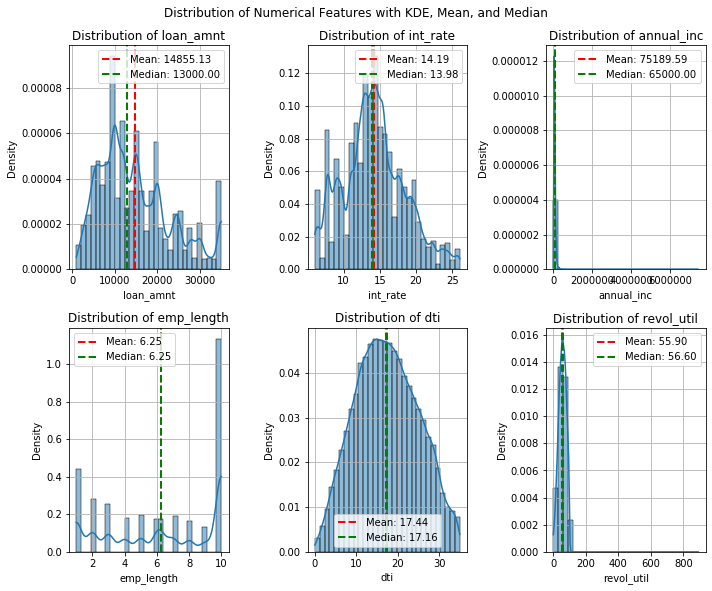

In [2]:
# Distribution of Numerical Features
numerical_columns = ['loan_amnt', 'int_rate', 'annual_inc', 'emp_length', 'dti', 'revol_util']

plt.figure(figsize=(10, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  
    sns.histplot(df[column], kde=True, bins=30, stat='density')
    
    mean_val = df[column].mean()
    median_val = df[column].median()
    
    # Add vertical lines for mean and median
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
    
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend(loc='best')
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Distribution of Numerical Features with KDE, Mean, and Median', y=1.02)
plt.show()

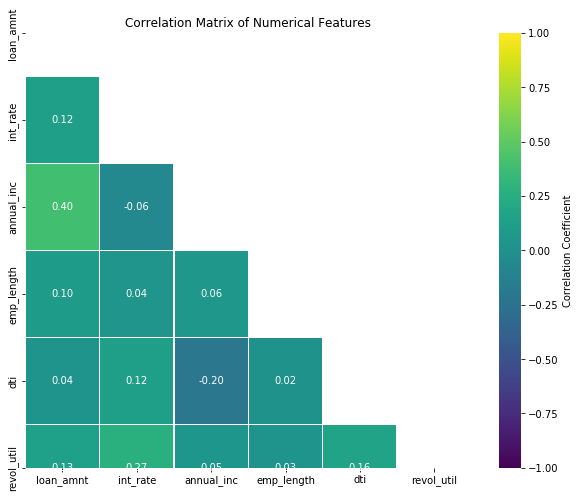

In [3]:
# heatmap for correlation matrix
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(10, 8))

# Mask the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5, mask=mask, 
            vmin=-1, vmax=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [4]:
# Modify the df to keep only the top 15 features based on Chi-squared Test on Training data

features  = ['id', 'member_id', 'loan_amnt', 'int_rate', 'annual_inc', 'percent_bc_gt_75', 'bc_util', 'dti', 
       'inq_last_6mths', 'mths_since_recent_inq', 'revol_util', 'total_bc_limit', 'tot_hi_cred_lim', 
       'tot_cur_bal', 'internal_score']

df = df[features]
print("\nModified DataFrame (Top 15 Features and Target 'bad_flag'):")
df.head()


Modified DataFrame (Top 15 Features and Target 'bad_flag'):


,id,member_id,loan_amnt,int_rate,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,tot_hi_cred_lim,tot_cur_bal,internal_score
0,20000001,22419852,10000,22.15,37000.0,80.0,83.0,28.51,1,3.0,73.1,16200,14877.170280,36809,131
1,20000002,22349118,1400,18.24,41000.0,0.0,0.0,26.58,0,9.0,11.5,4000,4097.304770,19536,19
2,20000003,22398818,7000,12.49,68900.0,60.0,75.9,6.60,0,11.0,48.1,11900,12688.495160,241465,92
3,20000004,22419015,18000,16.29,41000.0,33.3,61.1,20.61,1,0.0,38.1,7600,7908.799817,179757,235
4,20000005,22388614,12000,12.99,64000.0,75.0,67.0,24.61,0,6.0,57.9,21000,19378.561060,31953,157


In [5]:
# Save the DataFrame to a CSV file, excluding the index column
file_path = 'D:/processed_testing_loan_data.csv'
df.to_csv(file_path, index=False) 

 1    101479
-1      1026
Name: anomaly, dtype: int64


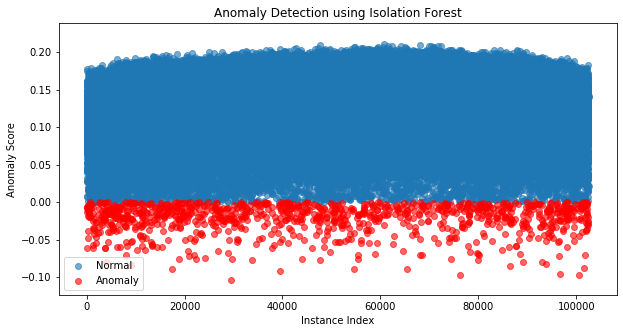

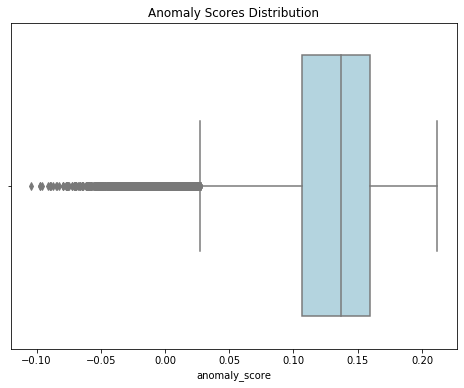

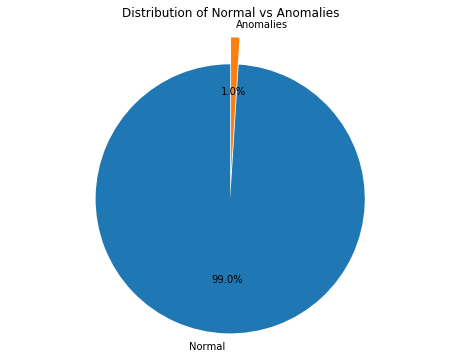

In [6]:
# anomaly detection using the Isolation Forest 

n_estimators = 100  # Number of trees in the forest
contamination = 0.01  # Expected proportion of outliers
sample_size = 256  # Number of samples to train each tree

features = df.select_dtypes(include=[np.number])  
iso_forest = IsolationForest(n_estimators=n_estimators,
                            contamination=contamination,
                            max_samples=sample_size,
                            random_state=123)
iso_forest.fit(features)

# Calculate anomaly scores and classify anomalies
df['anomaly_score'] = iso_forest.decision_function(features)  # Calculate anomaly score
df['anomaly'] = iso_forest.predict(features)  # Predict anomalies (1 for normal, -1 for anomaly)

# Check how many anomalies and normal instances
print(df['anomaly'].value_counts())

# Visualization of the results
plt.figure(figsize=(10, 5))

normal = df[df['anomaly'] == 1]  
plt.scatter(normal.index, normal['anomaly_score'], label='Normal', alpha=0.6)

anomalies = df[df['anomaly'] == -1]  
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly', color='red', alpha=0.6)

plt.xlabel("Instance Index")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Detection using Isolation Forest")
plt.legend()
plt.show()

# Box plot to better visualize the distribution of anomaly scores
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['anomaly_score'], color='lightblue')
plt.title('Anomaly Scores Distribution')
plt.show()

# Pie chart for the distribution of normal vs anomalies
labels = ['Normal', 'Anomalies']
sizes = [df[df['anomaly'] == 1].shape[0], df[df['anomaly'] == -1].shape[0]]  # Count normal vs anomalies

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0.2, 0))
plt.title('Distribution of Normal vs Anomalies')
plt.axis('equal')
plt.show()


The anomalies appear to be valid and may represent significant rare events, such as fraud or exceptional cases of loan defaults, and should therefore be retained

In [7]:
df['bad_flag']=np.nan
df.head()

,id,member_id,loan_amnt,int_rate,annual_inc,percent_bc_gt_75,bc_util,dti,inq_last_6mths,mths_since_recent_inq,revol_util,total_bc_limit,tot_hi_cred_lim,tot_cur_bal,internal_score,anomaly_score,anomaly,bad_flag
0,20000001,22419852,10000,22.15,37000.0,80.0,83.0,28.51,1,3.0,73.1,16200,14877.170280,36809,131,0.115904,1,NaN
1,20000002,22349118,1400,18.24,41000.0,0.0,0.0,26.58,0,9.0,11.5,4000,4097.304770,19536,19,0.032762,1,NaN
2,20000003,22398818,7000,12.49,68900.0,60.0,75.9,6.60,0,11.0,48.1,11900,12688.495160,241465,92,0.124508,1,NaN
3,20000004,22419015,18000,16.29,41000.0,33.3,61.1,20.61,1,0.0,38.1,7600,7908.799817,179757,235,0.144529,1,NaN
4,20000005,22388614,12000,12.99,64000.0,75.0,67.0,24.61,0,6.0,57.9,21000,19378.561060,31953,157,0.161886,1,NaN


In [8]:
# Save the DataFrame to a CSV file, excluding the index column
file_path = 'D:/processed_anomaly_testing_loan_data.csv'
df.to_csv(file_path, index=False) 